In [1]:
!nvidia-smi

Fri Aug 29 16:20:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip -q install ultralytics==8.2.103 opencv-python-headless==4.10.0.84 python-docx==1.1.2 matplotlib==3.9.0
from ultralytics import YOLO
import sys, os, shutil, glob, random, yaml, textwrap, json
from pathlib import Path
import cv2
import numpy as np
print("Setup OK.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.1/875.1 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 121.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 114.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 10.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
Creating new Ultralytics Settings v0.0.6 fil

In [3]:
from google.colab import files
up = files.upload()
zip_name = next(iter(up.keys()))

!mkdir -p /content/dataset_raw
!unzip -q "ToothNumber_TaskDataset.zip" -d /content/dataset_raw
!rsync -ah --progress /content/dataset_raw/ /content/dataset_raw_final/ || true
print("Unzipped to /content/dataset_raw_final")

Saving dataset.txt to dataset.txt
sending incremental file list
created directory /content/dataset_raw_final
./
images/
images/00147087-20240918-120248027.jpg
        142.43K 100%  104.58MB/s    0:00:00 (xfr#1, to-chk=994/998)
images/0337fb14-20240822-124747143.jpg
        142.68K 100%  136.07MB/s    0:00:00 (xfr#2, to-chk=993/998)
images/05473f26-20240924-154033777.jpg
        138.13K 100%  131.73MB/s    0:00:00 (xfr#3, to-chk=992/998)
images/05ff01fa-20250108-115407401.jpg
        146.61K 100%  139.82MB/s    0:00:00 (xfr#4, to-chk=991/998)
images/061339f1-20240911-110938655.jpg
        158.82K 100%   75.73MB/s    0:00:00 (xfr#5, to-chk=990/998)
images/069750f6-20240914-102814322.jpg
        137.65K 100%   65.64MB/s    0:00:00 (xfr#6, to-chk=989/998)
images/084c3562-20240827-154718191.jpg
        148.45K 100%   47.19MB/s    0:00:00 (xfr#7, to-chk=988/998)
images/0ba65172-20240821-105924223.jpg
        152.53K 100%   48.49MB/s    0:00:00 (xfr#8, to-chk=987/998)
images/0c4cebbe-20240813

In [6]:


from pathlib import Path
import shutil, random, os

root_in = Path('/content/dataset_raw_final')
root_out = Path('/content/dataset')

if root_out.exists():
    if root_out.is_file():
        root_out.unlink()
    else:
        shutil.rmtree(root_out)
root_out.mkdir(parents=True, exist_ok=True)

imgs = list(root_in.rglob('*.jpg')) + list(root_in.rglob('*.png')) + list(root_in.rglob('*.jpeg'))

labels = [p for p in root_in.rglob('*.txt') if p.name.lower() not in {'readme.txt', 'license.txt'}]

def stem(p): return p.stem

img_by_stem = {}
for p in imgs:
    img_by_stem.setdefault(stem(p), []).append(p)
label_by_stem = {stem(p): p for p in labels}

pairs = []
for s, img_list in img_by_stem.items():
    if s in label_by_stem:
        img = sorted(img_list, key=lambda x: (x.suffix.lower()!='.jpg', x.suffix.lower()))[0]
        pairs.append((img, label_by_stem[s]))

print(f"Found {len(pairs)} image/label pairs.")

random.seed(42)
random.shuffle(pairs)
n = len(pairs)
n_train, n_val = int(0.8*n), int(0.1*n)
splits = {
    'train': pairs[:n_train],
    'val':   pairs[n_train:n_train+n_val],
    'test':  pairs[n_train+n_val:],
}

for split in ['train','val','test']:
    (root_out/'images'/split).mkdir(parents=True, exist_ok=True)
    (root_out/'labels'/split).mkdir(parents=True, exist_ok=True)

for split in ['train','val','test']:
    for img, lab in splits[split]:
        shutil.copy2(img, root_out/'images'/split/img.name)
        shutil.copy2(lab, root_out/'labels'/split/(img.stem + '.txt'))

for split in ['train','val','test']:
    ni = len(list((root_out/'images'/split).glob('*.*')))
    nl = len(list((root_out/'labels'/split).glob('*.txt')))
    print(f"{split}: {ni} images, {nl} labels")


Found 497 image/label pairs.
train: 397 images, 397 labels
val: 49 images, 49 labels
test: 51 images, 51 labels


In [7]:
data_yaml = {
    'path': str(root_out),
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'names': [
        "Canine (13)",
        "Canine (23)",
        "Canine (33)",
        "Canine (43)",
        "Central Incisor (21)",
        "Central Incisor (41)",
        "Central Incisor (31)",
        "Central Incisor (11)",
        "First Molar (16)",
        "First Molar (26)",
        "First Molar (36)",
        "First Molar (46)",
        "First Premolar (14)",
        "First Premolar (34)",
        "First Premolar (44)",
        "First Premolar (24)",
        "Lateral Incisor (22)",
        "Lateral Incisor (32)",
        "Lateral Incisor (42)",
        "Lateral Incisor (12)",
        "Second Molar (17)",
        "Second Molar (27)",
        "Second Molar (37)",
        "Second Molar (47)",
        "Second Premolar (15)",
        "Second Premolar (25)",
        "Second Premolar (35)",
        "Second Premolar (45)",
        "Third Molar (18)",
        "Third Molar (28)",
        "Third Molar (38)",
        "Third Molar (48)"
    ]
}
Path('data.yaml').write_text(yaml.safe_dump(data_yaml, sort_keys=False))
print(Path('data.yaml').read_text())


path: /content/dataset
train: images/train
val: images/val
test: images/test
names:
- Canine (13)
- Canine (23)
- Canine (33)
- Canine (43)
- Central Incisor (21)
- Central Incisor (41)
- Central Incisor (31)
- Central Incisor (11)
- First Molar (16)
- First Molar (26)
- First Molar (36)
- First Molar (46)
- First Premolar (14)
- First Premolar (34)
- First Premolar (44)
- First Premolar (24)
- Lateral Incisor (22)
- Lateral Incisor (32)
- Lateral Incisor (42)
- Lateral Incisor (12)
- Second Molar (17)
- Second Molar (27)
- Second Molar (37)
- Second Molar (47)
- Second Premolar (15)
- Second Premolar (25)
- Second Premolar (35)
- Second Premolar (45)
- Third Molar (18)
- Third Molar (28)
- Third Molar (38)
- Third Molar (48)



In [8]:
def check_labels(lbl_dir):
    bad = 0
    for p in Path(lbl_dir).rglob('*.txt'):
        with open(p) as f:
            for line in f:
                vals = line.strip().split()
                if len(vals) != 5: bad += 1; continue
                cid = int(vals[0])
                nums = list(map(float, vals[1:]))
                if not (0 <= cid <= 31): bad += 1
                if not all(0 <= x <= 1 for x in nums): bad += 1
    return bad

bad_cnt = sum(check_labels(d) for d in [root_out/'labels/train', root_out/'labels/val', root_out/'labels/test'])
print("Label issues found:", bad_cnt)

Label issues found: 4


In [9]:
from pathlib import Path
import shutil, json, cv2, numpy as np

root_out = Path('/content/dataset')
backup_dir = Path('/content/label_backups'); backup_dir.mkdir(exist_ok=True, parents=True)
quarantine = Path('/content/quarantine');   (quarantine/'images').mkdir(parents=True, exist_ok=True); (quarantine/'labels').mkdir(parents=True, exist_ok=True)

def diagnose_and_fix(root_out, n_classes=32, attempt_fix=True):
    report = {}
    total_issues_before = 0
    total_fixed = 0
    total_quarantined = 0

    for split in ['train','val','test']:
        lbl_dir = root_out/'labels'/split
        img_dir = root_out/'images'/split
        if not lbl_dir.exists(): continue

        for lp in lbl_dir.rglob('*.txt'):
            stem = lp.stem
            candidates = [img_dir/f"{stem}.jpg", img_dir/f"{stem}.png", img_dir/f"{stem}.jpeg"]
            imgp = next((p for p in candidates if p.exists()), None)

            file_issues = []
            fixed_lines = []
            changed = False

            with open(lp, 'r') as f:
                lines = [ln.strip() for ln in f if ln.strip()]

            for ln in lines:
                parts = ln.split()
                if len(parts) != 5:
                    file_issues.append(("wrong_columns", ln))
                    continue

                try:
                    cid = int(float(parts[0]))
                except:
                    file_issues.append(("bad_class", ln)); continue

                try:
                    cx, cy, w, h = map(float, parts[1:])
                except:
                    file_issues.append(("bad_numbers", ln)); continue

                if not (0 <= cid < n_classes):
                    file_issues.append(("class_out_of_range", ln))
                    continue

                pixel_like = any(v > 1.5 for v in [cx, cy, w, h])

                if pixel_like and attempt_fix and imgp is not None and imgp.exists():
                    im = cv2.imread(str(imgp))
                    if im is None:
                        file_issues.append(("cannot_read_image_for_fix", ln))
                        continue
                    H, W = im.shape[:2]
                    cx, cy, w, h = cx / W, cy / H, w / W, h / H
                    changed = True

                cx2 = float(np.clip(cx, 0.0, 1.0))
                cy2 = float(np.clip(cy, 0.0, 1.0))
                w2  = float(np.clip(w,  0.0, 1.0))
                h2  = float(np.clip(h,  0.0, 1.0))
                if (cx2,cy2,w2,h2) != (cx,cy,w,h): changed = True

                if w2 <= 0 or h2 <= 0:
                    file_issues.append(("zero_area_after_clip", ln))
                    continue

                fixed_lines.append(f"{cid} {cx2:.6f} {cy2:.6f} {w2:.6f} {h2:.6f}")

            issues_before = len(file_issues)
            total_issues_before += issues_before

            if issues_before == 0 and not changed:
                continue

            if len(fixed_lines) > 0:
                bkp = backup_dir / (lp.name + ".bak")
                if not bkp.exists():
                    shutil.copy2(lp, bkp)

                with open(lp, 'w') as f:
                    f.write("\n".join(fixed_lines) + "\n")

                total_fixed += 1
            else:
                (quarantine/'labels').mkdir(exist_ok=True, parents=True)
                qlp = quarantine/'labels'/lp.name
                shutil.move(str(lp), str(qlp))
                if imgp and imgp.exists():
                    (quarantine/'images').mkdir(exist_ok=True, parents=True)
                    qip = quarantine/'images'/imgp.name
                    shutil.move(str(imgp), str(qip))
                total_quarantined += 1

            report[str(lp)] = {
                "issues_found": issues_before,
                "changed_file": changed,
                "lines_kept": len(fixed_lines),
                "notes": [k for k,_ in file_issues]
            }

    summary = {
        "total_issues_before": total_issues_before,
        "files_modified": total_fixed,
        "files_quarantined": total_quarantined,
        "report_size": len(report)
    }
    return summary, report

summary, rep = diagnose_and_fix(root_out, n_classes=32, attempt_fix=True)
print(json.dumps(summary, indent=2)[:2000])


{
  "total_issues_before": 4,
  "files_modified": 3,
  "files_quarantined": 0,
  "report_size": 3
}


In [10]:
bad_cnt = sum(check_labels(d) for d in [root_out/'labels/train', root_out/'labels/val', root_out/'labels/test'])
print("Label issues found (after fix):", bad_cnt)

Label issues found (after fix): 0


In [1]:
import numpy as np
from numpy.random import RandomState
print("NumPy OK:", np.__version__)

NumPy OK: 2.2.6


In [2]:
from ultralytics import YOLO

model = YOLO('yolov8s.pt')
results = model.train(
    data='data.yaml',
    imgsz=640,
    epochs=100,
    batch=-1,
    device=0,
    project='runs',
    name='tooth_yolov8s',
    seed=42,
    patience=20,
    verbose=True,
    plots=True
)
print("Training started. Artifacts -> /content/runs/detect/tooth_yolov8s")


WARNING ⚠️ Ultralytics settings reset to default values. This may be due to a possible problem with your settings or a recent ultralytics package update. 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu128 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_

In [4]:
# === Get the exact run folder and checkpoint saved by training ===
from pathlib import Path
from ultralytics import YOLO
import glob, os

# 1) Find the run directory
try:
    run_dir = Path(results.save_dir)  # preferred (works on recent Ultralytics)
except Exception:
    # fallback via model.trainer
    run_dir = Path(getattr(getattr(model, "trainer", None), "save_dir", "runs/detect/tooth_yolov8s"))

print("Run directory:", run_dir)

# 2) Resolve checkpoint path (prefer best.pt, else last.pt)
best_pt = run_dir / "weights" / "best.pt"
last_pt = run_dir / "weights" / "last.pt"

if best_pt.exists():
    ckpt_path = str(best_pt)
elif last_pt.exists():
    ckpt_path = str(last_pt)
else:
    # final fallback: most recent *.pt under runs/detect/**/weights/
    cand = sorted(glob.glob("runs/detect/*/weights/*.pt"), key=os.path.getmtime, reverse=True)
    if not cand:
        raise FileNotFoundError("No checkpoint found. Did training finish and save weights?")
    ckpt_path = cand[0]

print("Using checkpoint:", ckpt_path)

# 3) Evaluate on test split
best = YOLO(ckpt_path)
test_metrics = best.val(
    data='data.yaml',
    split='test',
    imgsz=640,
    conf=0.001,
    iou=0.6,
    plots=True,
    save_json=True
)

# (Optional) pretty print key metrics
rd = getattr(test_metrics, "results_dict", {})
for k in ['metrics/precision(B)','metrics/recall(B)','metrics/mAP50(B)','metrics/mAP50-95(B)']:
    if k in rd:
        print(f"{k.split('/')[-1]}: {rd[k]:.4f}")


Run directory: runs/tooth_yolov8s
Using checkpoint: runs/tooth_yolov8s/weights/best.pt
Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu128 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,137,968 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 18.4±11.8 MB/s, size: 105.8 KB)
val: Scanning /content/dataset/labels/test... 51 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 51/51 600.4it/s 0.1s
val: New cache created: /content/dataset/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 0.85it/s 4.7s
                   all         51       1436      0.888       0.92      0.942      0.659
           Canine (13)         48         48      0.884      0.917      0.936       0.65
           Canine (23)         47         48      0.896      0.894      0.913      0.613
           Canine (33)         49         49       0.93      0.939      0.965      0.661
   

In [7]:
# === Robust: reload the newest checkpoint and evaluate on test ===
from ultralytics import YOLO
from pathlib import Path
import glob, os

# 1) Try to use the run you just trained (if 'results' is still in memory)
candidates = []
try:
    run_dir = Path(results.save_dir)  # preferred
    candidates += [str(run_dir / "weights" / "best.pt"),
                   str(run_dir / "weights" / "last.pt")]
except Exception:
    pass

# 2) Also scan everything under runs/ for safety (handles tooth_yolov8s2, ...3, etc.)
candidates += sorted(glob.glob("runs/detect/*/weights/best.pt"), key=os.path.getmtime, reverse=True)
candidates += sorted(glob.glob("runs/detect/*/weights/last.pt"), key=os.path.getmtime, reverse=True)

# 3) Pick the first file that actually exists
ckpt = next((p for p in candidates if Path(p).exists()), None)
if ckpt is None:
    # Helpful listing so you can see what's there
    print("No checkpoint found. Here is what's under runs/:")
    for p in sorted(Path("runs").rglob("*")):
        if p.is_file() and p.suffix == ".pt":
            print(" -", p)
    raise FileNotFoundError("No best.pt/last.pt found. Did training finish and save weights?")

print("Using checkpoint:", ckpt)
best = YOLO(ckpt)

# 4) Evaluate on your test split
test_metrics = best.val(
    data='data.yaml',
    split='test',
    imgsz=640,
    conf=0.001,
    iou=0.6,
    plots=True,
    save_json=True
)
print(test_metrics)

# Optional: pretty print key metrics
rd = getattr(test_metrics, "results_dict", {})
for k in ['metrics/precision(B)','metrics/recall(B)','metrics/mAP50(B)','metrics/mAP50-95(B)']:
    if k in rd:
        print(f"{k.split('/')[-1]}: {rd[k]:.4f}")


Using checkpoint: runs/tooth_yolov8s/weights/best.pt
Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu128 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,137,968 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2054.3±607.9 MB/s, size: 57.7 KB)
val: Scanning /content/dataset/labels/test.cache... 51 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 51/51 84482.4it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 0.87it/s 4.6s
                   all         51       1436      0.888       0.92      0.942      0.659
           Canine (13)         48         48      0.884      0.917      0.936       0.65
           Canine (23)         47         48      0.896      0.894      0.913      0.613
           Canine (33)         49         49       0.93      0.939      0.965      0.661
           Canine (43)         49         49      0.856      0.968      0.947      0.6

In [9]:
try:
    # results.csv contains epoch-wise, but val() returns a rich object too
    print("mAP50:", float(test_metrics.results_dict.get('metrics/mAP50(B)')))
    print("mAP50-95:", float(test_metrics.results_dict.get('metrics/mAP50-95(B)')))
    print("Precision:", float(test_metrics.results_dict.get('metrics/precision(B)')))
    print("Recall:", float(test_metrics.results_dict.get('metrics/recall(B)')))
except Exception as e:
    print("Metrics keys layout changed:", e)


mAP50: 0.9421726895583753
mAP50-95: 0.6594651632144901
Precision: 0.8877293412717584
Recall: 0.9196003082588431



image 1/51 /content/dataset/images/test/00147087-20240918-120248027.jpg: 640x640 1 Canine (13), 1 Canine (23), 2 Canine (33)s, 1 Canine (43), 1 Central Incisor (21), 1 Central Incisor (41), 1 Central Incisor (31), 1 Central Incisor (11), 1 First Molar (16), 1 First Molar (26), 1 First Molar (36), 1 First Molar (46), 1 First Premolar (14), 1 First Premolar (34), 1 First Premolar (44), 1 First Premolar (24), 2 Lateral Incisor (22)s, 1 Lateral Incisor (32), 1 Lateral Incisor (42), 1 Lateral Incisor (12), 1 Second Molar (17), 1 Second Molar (27), 1 Second Premolar (15), 1 Second Premolar (25), 1 Second Premolar (35), 1 Second Premolar (45), 1 Third Molar (18), 1 Third Molar (48), 16.4ms
image 2/51 /content/dataset/images/test/05ff01fa-20250108-115407401.jpg: 640x640 1 Canine (13), 1 Canine (23), 1 Canine (33), 1 Canine (43), 1 Central Incisor (21), 2 Central Incisor (41)s, 1 Central Incisor (31), 2 Central Incisor (11)s, 1 First Molar (16), 1 First Molar (26), 1 First Molar (36), 1 First 

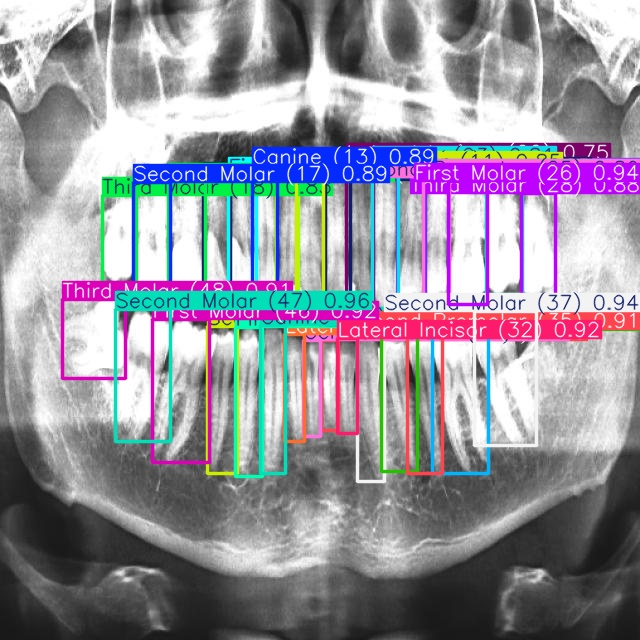

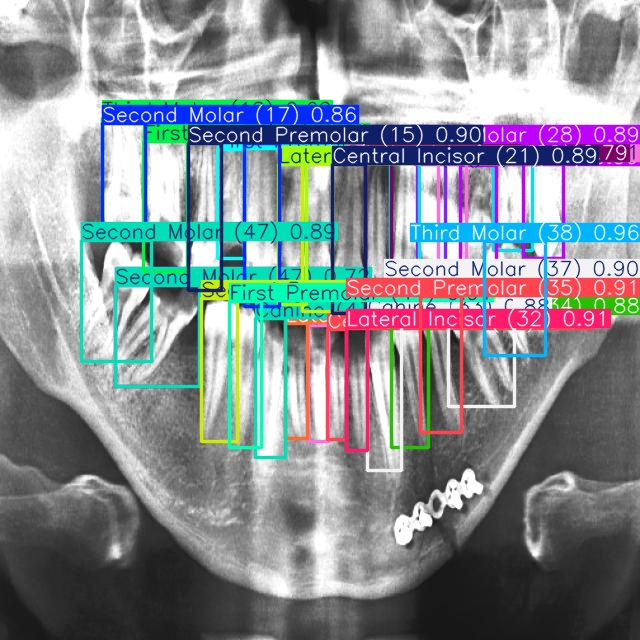

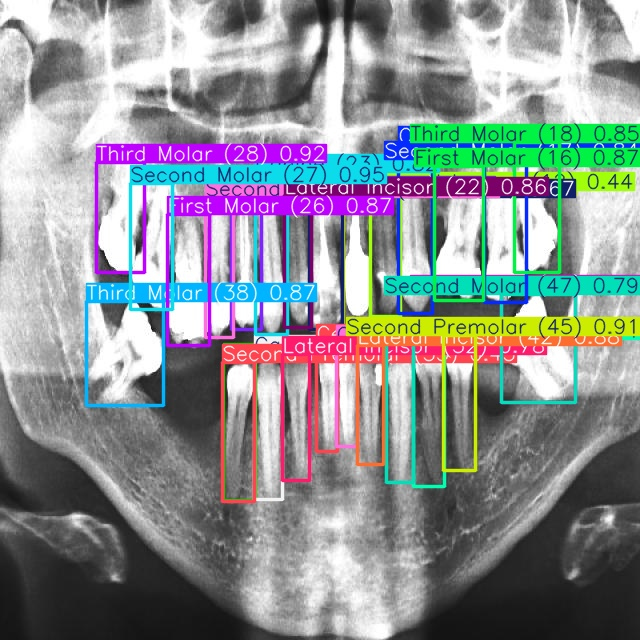

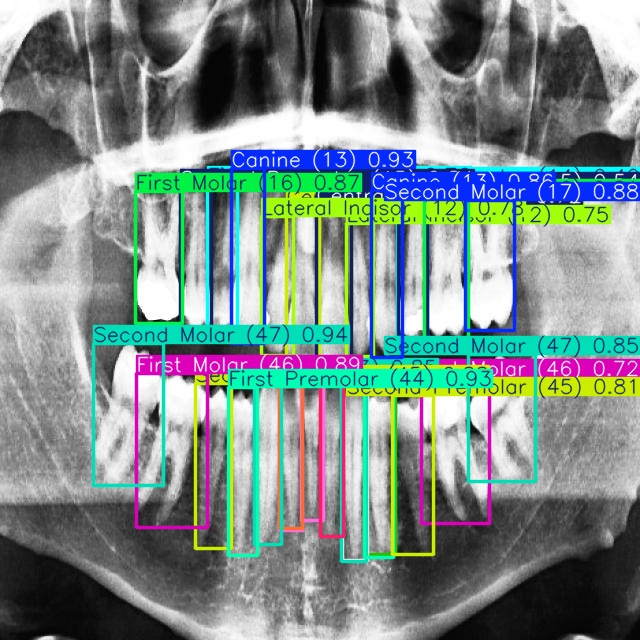

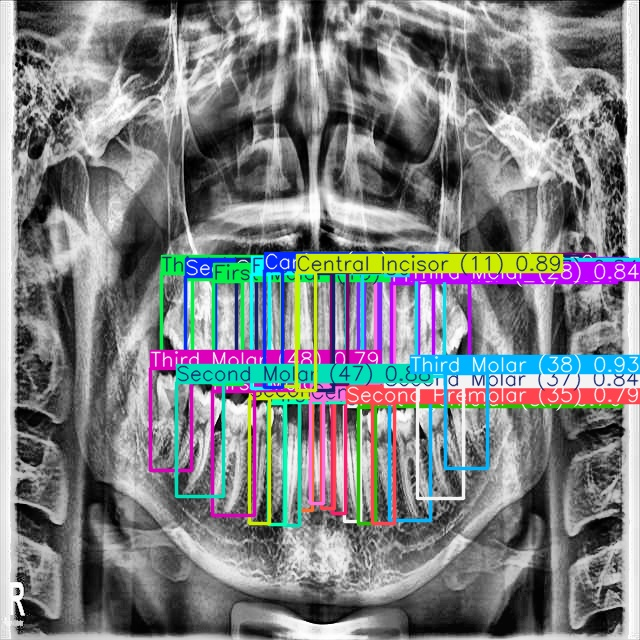

Showing 5 of 51 images from runs/pred_test


In [11]:
# --- Predict on test set (robust to restarts) ---

from pathlib import Path
import yaml, glob, os
from ultralytics import YOLO

# 1) Recover dataset root (from data.yaml) if root_out is missing
try:
    root_out
except NameError:
    with open('data.yaml') as f:
        cfg = yaml.safe_load(f)
    root_out = Path(cfg.get('path', '/content/dataset'))

# 2) Ensure we have a model in memory (recover latest checkpoint if needed)
try:
    best
except NameError:
    cands = sorted(glob.glob("runs/detect/*/weights/best.pt"), key=os.path.getmtime, reverse=True)
    if not cands:
        cands = sorted(glob.glob("runs/detect/*/weights/last.pt"), key=os.path.getmtime, reverse=True)
    if not cands:
        raise FileNotFoundError("No trained weights found under runs/detect/**/weights/*.pt")
    best = YOLO(cands[0])
    print("Loaded checkpoint:", cands[0])

# 3) Predict
pred = best.predict(
    source=str(root_out/'images'/'test'),
    imgsz=640,
    conf=0.25,
    iou=0.6,
    save=True,
    save_txt=True,
    project='runs',
    name='pred_test',
    exist_ok=True,   # avoid 'directory exists' error
)

# 4) Show a few predicted images
from IPython.display import Image, display

# Get the actual output folder from the prediction result (safer than hard-coding)
try:
    pred_dir = Path(pred[0].save_dir)  # Ultralytics returns a list of Results
except Exception:
    pred_dir = Path('runs/pred_test')

# Support multiple extensions
out_imgs = []
for ext in ('*.jpg', '*.png', '*.jpeg'):
    out_imgs.extend(pred_dir.rglob(ext))

for img_path in out_imgs[:5]:
    display(Image(filename=str(img_path), width=900))

print(f"Showing {min(5, len(out_imgs))} of {len(out_imgs)} images from {pred_dir}")


In [17]:
# === Install YOLOv5 (stable tag) and deps ===
%cd /content
!rm -rf yolov5
!git clone -q --depth 1 -b v7.0 https://github.com/ultralytics/yolov5
%cd yolov5
!pip -q install -r requirements.txt "numpy>=2.0,<2.4" matplotlib==3.9.0

# === Train (YOLOv5s) ===
!python train.py \
  --img 640 --epochs 100 --batch -1 \
  --data /content/data.yaml \
  --weights yolov5s.pt \
  --project /content/runs_v5 --name tooth_yolov5 --exist-ok

# === Evaluate on the TEST split ===
# (If your yolov5 version complains about --task test, remove it or switch to latest master)
!python val.py \
  --img 640 \
  --data /content/data.yaml \
  --weights /content/runs_v5/tooth_yolov5/weights/best.pt \
  --task test \
  --conf 0.001 --iou 0.6 \
  --project /content/runs_v5 --name tooth_v5_test --exist-ok --plots --save-json

# Optional predictions (boxes) on test images
!python detect.py \
  --weights /content/runs_v5/tooth_yolov5/weights/best.pt \
  --img 640 --conf 0.25 --iou 0.6 \
  --source /content/dataset/images/test \
  --project /content/runs_v5 --name pred_test --exist-ok --save-txt

%cd /content


/content
Note: switching to '915bbf294bb74c859f0b41f1c23bc395014ea679'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

/content/yolov5
/content/yolov5/utils/general.py:34: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg
E0000 00:00:1756492617.525098   34851 cuda_dnn.cc:8579] Unable to register cuDNN facto

In [13]:
# === Install Ultralytics (YOLOv8/YOLOv11 engine) ===
!pip -q install -U "ultralytics==8.3.189" "numpy>=2.0,<2.4" opencv-python-headless==4.10.0.84

from ultralytics import YOLO
from pathlib import Path
import os, glob, yaml

# === Train (YOLOv11s) ===
model = YOLO('yolo11s.pt')  # you can try yolo11m.pt if GPU is strong
results_v11 = model.train(
    data='/content/data.yaml',
    imgsz=640,
    epochs=100,
    batch=-1,
    device=0,
    project='/content/runs_v11',
    name='tooth_yolo11s',
    exist_ok=True,
    seed=42,
    patience=20,
    verbose=True,
    plots=True
)
print("Run dir:", results_v11.save_dir)

# === Evaluate on TEST split ===
ckpt_v11 = Path(results_v11.save_dir) / 'weights' / 'best.pt'
if not ckpt_v11.exists():
    # fallback to the newest best/last under runs_v11
    cands = sorted(glob.glob('/content/runs_v11/*/weights/best.pt'), key=os.path.getmtime, reverse=True) \
         or sorted(glob.glob('/content/runs_v11/*/weights/last.pt'), key=os.path.getmtime, reverse=True)
    assert cands, "No YOLOv11 checkpoint found"
    ckpt_v11 = Path(cands[0])

print("Using checkpoint:", ckpt_v11)
best_v11 = YOLO(str(ckpt_v11))

metrics_v11 = best_v11.val(
    data='/content/data.yaml',
    split='test',      # <— uses your 'test:' from data.yaml
    imgsz=640,
    conf=0.001,
    iou=0.6,
    plots=True,
    save_json=True,
    project='/content/runs_v11',
    name='tooth_yolo11s_test',
    exist_ok=True
)
print(metrics_v11)

# === Optional predictions on TEST images ===
pred_v11 = best_v11.predict(
    source='/content/dataset/images/test',
    imgsz=640,
    conf=0.25,
    iou=0.6,
    save=True,
    save_txt=True,
    project='/content/runs_v11',
    name='pred_test',
    exist_ok=True
)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.8 MB/s eta 0:00:00
Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu128 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=tooth_yolo11s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_

In [14]:
# --- Compare YOLOv5 / YOLOv8 / YOLOv11 on the SAME test set ---

import os, glob, yaml, re
from pathlib import Path
import pandas as pd
import numpy as np

# Ensure data.yaml exists
data_yaml = '/content/data.yaml'
assert Path(data_yaml).exists(), "data.yaml not found"

with open(data_yaml) as f:
    cfg = yaml.safe_load(f)
print("Using dataset root:", cfg.get('path'), "\nTest split:", cfg.get('test'))

# -------- Find checkpoints --------
def latest(path_glob):
    cands = sorted(glob.glob(path_glob), key=os.path.getmtime, reverse=True)
    return cands[0] if cands else None

ckpts = {
    "YOLOv5s": latest("/content/runs_v5/*/weights/best.pt"),
    "YOLOv8s": latest("/content/runs/detect/*/weights/best.pt"),
    "YOLOv11s": latest("/content/runs_v11/*/weights/best.pt"),
}
print("Checkpoints found:", ckpts)

# -------- Evaluate YOLOv8/11 via Ultralytics Python API --------
try:
    from ultralytics import YOLO
except Exception as e:
    raise RuntimeError("Ultralytics not installed. Re-run your YOLOv8/11 install cell.") from e

def eval_ultralytics(ckpt_path, model_name):
    if ckpt_path is None:
        return None
    m = YOLO(ckpt_path)
    res = m.val(
        data=data_yaml,
        split='test',
        imgsz=640,
        conf=0.001,
        iou=0.6,
        plots=False,
        save_json=False,
        verbose=False
    )
    rd = getattr(res, "results_dict", {}) or {}
    return {
        "model": model_name,
        "precision": float(rd.get("metrics/precision(B)", np.nan)),
        "recall": float(rd.get("metrics/recall(B)", np.nan)),
        "mAP@50": float(rd.get("metrics/mAP50(B)", np.nan)),
        "mAP@50-95": float(rd.get("metrics/mAP50-95(B)", np.nan)),
        "ckpt": ckpt_path
    }

rows = []

# YOLOv8
rows.append(eval_ultralytics(ckpts["YOLOv8s"], "YOLOv8s"))

# YOLOv11
rows.append(eval_ultralytics(ckpts["YOLOv11s"], "YOLOv11s"))

# -------- Evaluate YOLOv5 by parsing its results.txt (from your earlier val.py run) --------
# If you already ran the YOLOv5 val command with --task test --save-json, it creates a run like /content/runs_v5/tooth_v5_test/
# We'll parse the newest *test*/results.txt for the "all" line:  all  P  R  mAP@.5  mAP@.5:.95
def parse_yolov5_metrics():
    res_files = sorted(glob.glob("/content/runs_v5/*test*/results.txt"), key=os.path.getmtime, reverse=True)
    if not res_files:
        # try without *test* (some versions save under the train run)
        res_files = sorted(glob.glob("/content/runs_v5/*/results.txt"), key=os.path.getmtime, reverse=True)
    if not res_files:
        print("No YOLOv5 results.txt found; re-run YOLOv5 val.py on test.")
        return None
    txt = Path(res_files[0]).read_text().strip().splitlines()
    all_line = None
    for ln in txt:
        if ln.strip().startswith("all "):
            all_line = ln
            break
    if all_line is None:
        # fallback: search floats in a line containing "all"
        for ln in txt:
            if "all" in ln:
                all_line = ln; break
    if all_line is None:
        print("Could not parse YOLOv5 results.txt")
        return None

    # Expect: "all  P  R  mAP@.5  mAP@.5:.95"
    nums = [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", all_line)]
    # Usually nums has 4 floats; if there's an extra integer (like class index) we keep last 4 floats
    if len(nums) >= 4:
        P, R, m50, m5095 = nums[-4], nums[-3], nums[-2], nums[-1]
        return {
            "model": "YOLOv5s",
            "precision": P,
            "recall": R,
            "mAP@50": m50,
            "mAP@50-95": m5095,
            "ckpt": ckpts["YOLOv5s"]
        }
    print("Unexpected YOLOv5 results format:", all_line)
    return None

rows.append(parse_yolov5_metrics())

# -------- Assemble comparison table --------
rows = [r for r in rows if r is not None]
assert rows, "No metrics gathered—make sure all three models were trained/evaluated."

df = pd.DataFrame(rows).sort_values("mAP@50-95", ascending=False)
print(df)

# Save for your report
out_csv = "/content/model_comparison.csv"
df.to_csv(out_csv, index=False)
print("Saved:", out_csv)


Using dataset root: /content/dataset 
Test split: images/test
Checkpoints found: {'YOLOv5s': None, 'YOLOv8s': None, 'YOLOv11s': '/content/runs_v11/tooth_yolo11s/weights/best.pt'}
Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu128 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,425,184 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1622.7±347.8 MB/s, size: 75.2 KB)
val: Scanning /content/dataset/labels/test.cache... 51 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 51/51 69069.9it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 3.2it/s 1.2s
                   all         51       1436      0.918      0.916      0.959      0.672
Speed: 0.5ms preprocess, 10.6ms inference, 0.0ms loss, 3.1ms postprocess per image
No YOLOv5 results.txt found; re-run YOLOv5 val.py on test.
      model  precision    recall    mAP@50  mAP@50-95  \
0  YOLOv11s   0.917627  0.9

Results saved to /content/pred_YOLOv11s

Image: cate8-00455_jpg.rf.8e80789ad78df1b7a463e8e13c2a4dd3.jpg


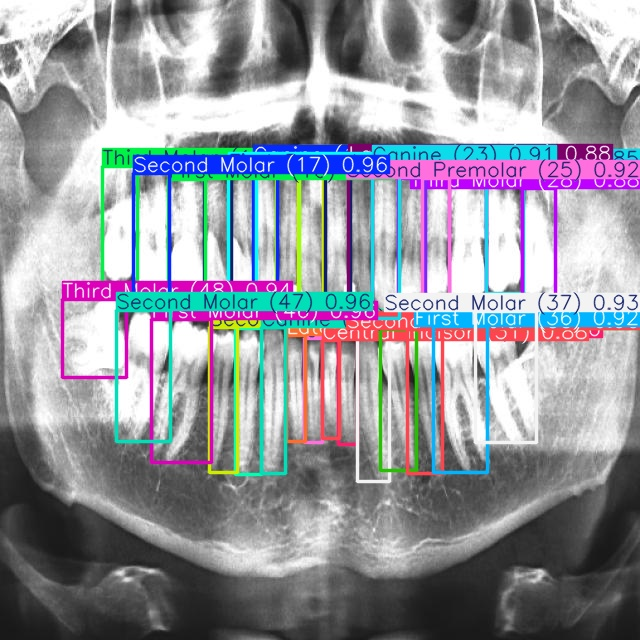

YOLOv11s

Image: cate8-00267_jpg.rf.8303c47ab0c59b7d7ae202f0041fcf20.jpg


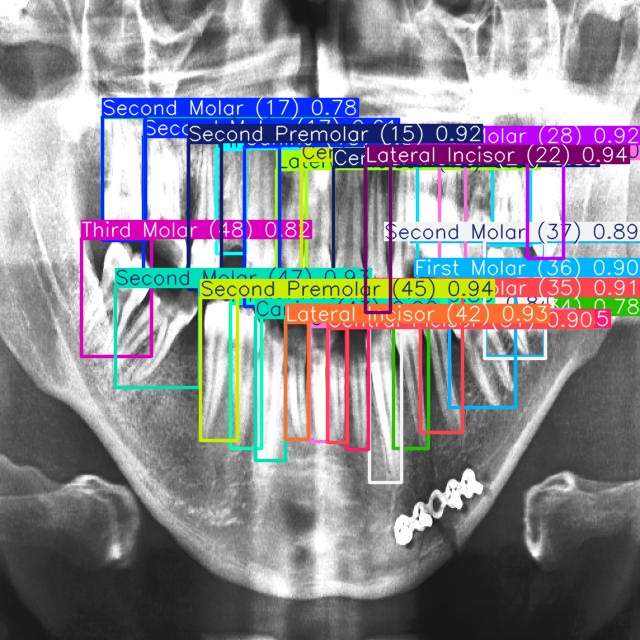

YOLOv11s

Image: cate8-00181_jpg.rf.54bc1d793ffc53d9c3e5b6cb3662822e.jpg


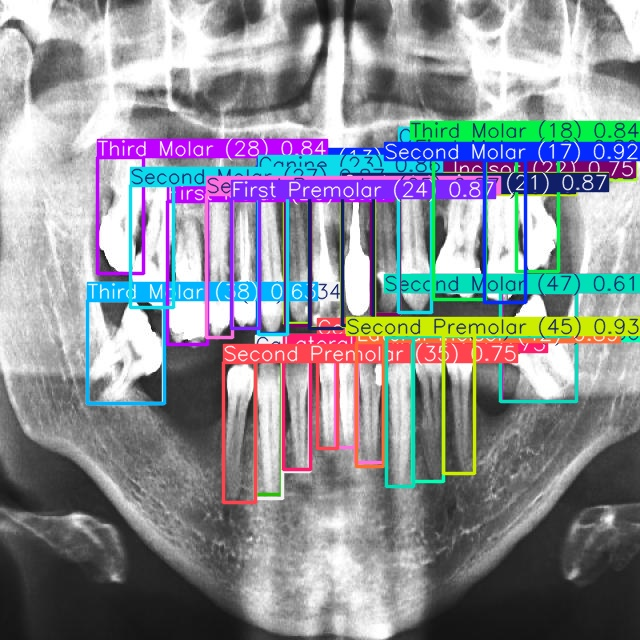

YOLOv11s


In [15]:
from ultralytics import YOLO
from pathlib import Path
import glob, os, random
from IPython.display import display, Image

test_dir = Path(cfg["path"]) / cfg["test"] if isinstance(cfg["test"], str) and not str(cfg["test"]).startswith("/") else Path("/content/dataset/images/test")
if not test_dir.exists():  # fallback to our earlier layout
    test_dir = Path("/content/dataset/images/test")

# pick a few test images
imgs = []
for ext in ("*.jpg","*.png","*.jpeg"):
    imgs.extend(test_dir.rglob(ext))
random.seed(0)
sample = imgs[:3] if len(imgs) >= 3 else imgs

pred_dirs = {}
for name, ckpt in ckpts.items():
    if ckpt is None:
        continue
    model = YOLO(ckpt)
    outdir = f"/content/pred_{name}"
    model.predict(
        source=[str(p) for p in sample],
        imgsz=640, conf=0.25, iou=0.6,
        save=True, project="/content", name=f"pred_{name}", exist_ok=True, verbose=False
    )
    pred_dirs[name] = Path(outdir)

# display
for p in sample:
    print("\nImage:", p.name)
    for name, outdir in pred_dirs.items():
        # find the corresponding rendered image (Ultralytics keeps original filename)
        cands = list(outdir.rglob(p.name))
        if cands:
            display(Image(filename=str(cands[0]), width=900))
            print(name)


In [1]:
# --- Ultralytics (YOLOv8/YOLOv11): evaluation helper ---
from ultralytics import YOLO
from pathlib import Path
from IPython.display import Image, display
import pandas as pd, glob, os

def eval_ultra(ckpt_path,
               data_yaml='/content/data.yaml',
               imgsz=640, conf=0.001, iou=0.6,
               project='/content/runs_eval', name='eval_ultra'):
    """Runs Ultralytics .val() on the TEST split, saves plots and key_metrics.csv, displays confusion_matrix.png."""
    ckpt_path = str(ckpt_path)
    print("Using checkpoint:", ckpt_path)
    model = YOLO(ckpt_path)
    res = model.val(
        data=data_yaml,
        split='test',
        imgsz=imgsz,
        conf=conf,
        iou=iou,
        plots=True,       # <- saves confusion_matrix.png, PR_curve.png, etc.
        save_json=True,   # <- COCO-style json (optional)
        project=project,
        name=name,
        exist_ok=True,
        verbose=False
    )
    run_dir = Path(res.save_dir)
    rd = getattr(res, "results_dict", {}) or {}
    # Extract common keys (handle slight key-name variations across versions)
    def get(rd, *keys):
        for k in keys:
            if k in rd: return float(rd[k])
        return float('nan')

    metrics = {
        "precision": get(rd, "metrics/precision(B)", "metrics/precision"),
        "recall":    get(rd, "metrics/recall(B)",    "metrics/recall"),
        "mAP@50":    get(rd, "metrics/mAP50(B)",     "metrics/mAP50"),
        "mAP@50-95": get(rd, "metrics/mAP50-95(B)",  "metrics/mAP50-95"),
        "run_dir":   str(run_dir)
    }
    # Save CSV
    df = pd.DataFrame([metrics])
    df.to_csv(run_dir/'key_metrics.csv', index=False)
    print("Saved key metrics to:", run_dir/'key_metrics.csv')

    # Show confusion matrix image
    cm = run_dir/'confusion_matrix.png'
    if cm.exists():
        display(Image(filename=str(cm), width=900))
    else:
        print("confusion_matrix.png not found at", cm)

    print("Metrics:", metrics)
    return metrics, run_dir

# ---- Example calls (pick the ones you trained) ----
# YOLOv11
# eval_ultra('/content/runs_v11/tooth_yolo11s/weights/best.pt',
#            project='/content/runs_v11', name='tooth_yolo11s_test')

# YOLOv8
# eval_ultra(sorted(glob.glob('runs/detect/*/weights/best.pt'), key=os.path.getmtime)[-1],
#            project='/content/runs_v8', name='tooth_yolov8_test')


In [2]:
# --- YOLOv5: parse results + show confusion matrix ---
from pathlib import Path
from IPython.display import Image, display
import glob, os, re, pandas as pd

def eval_v5(project='/content/runs_v5'):
    """
    Finds the newest YOLOv5 test run under project/*, parses results.txt (line 'all'),
    shows confusion_matrix.png, and writes key_metrics_v5.csv.
    """
    # Prefer runs that look like your test eval (e.g., *test*), fallback to newest results.txt
    res_txts = sorted(glob.glob(f"{project}/*test*/results.txt"), key=os.path.getmtime, reverse=True)
    if not res_txts:
        res_txts = sorted(glob.glob(f"{project}/*/results.txt"), key=os.path.getmtime, reverse=True)
    assert res_txts, f"No results.txt found under {project} — run val.py on the test split first."

    res_txt = Path(res_txts[0])
    run_dir = res_txt.parent
    print("Parsing:", res_txt)

    # Grab the 'all' line -> "all  P  R  mAP@.5  mAP@.5:.95 ..."
    all_line = None
    for ln in res_txt.read_text().splitlines():
        if ln.strip().startswith("all "):
            all_line = ln; break
    if all_line is None:
        # fallback: any line containing "all"
        for ln in res_txt.read_text().splitlines():
            if "all" in ln:
                all_line = ln; break
    assert all_line, "Could not find 'all' line in results.txt"

    nums = [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", all_line)]
    # Usually last 4 floats correspond to P, R, mAP@.5, mAP@.5:.95
    if len(nums) < 4:
        raise ValueError(f"Unexpected results format: {all_line}")
    P, R, m50, m5095 = nums[-4], nums[-3], nums[-2], nums[-1]

    metrics = {
        "precision": P,
        "recall": R,
        "mAP@50": m50,
        "mAP@50-95": m5095,
        "run_dir": str(run_dir)
    }
    pd.DataFrame([metrics]).to_csv(run_dir/'key_metrics_v5.csv', index=False)
    print("Saved key metrics to:", run_dir/'key_metrics_v5.csv')

    # Show confusion matrix (generated by val.py)
    cm = run_dir/'confusion_matrix.png'
    if cm.exists():
        display(Image(filename=str(cm), width=900))
    else:
        print("confusion_matrix.png not found at", cm)

    print("Metrics:", metrics)
    return metrics, run_dir

# ---- Example call ----
# eval_v5('/content/runs_v5')


Using checkpoint: /content/runs_v11/tooth_yolo11s/weights/best.pt
Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu128 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,425,184 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1336.2±309.7 MB/s, size: 55.8 KB)
val: Scanning /content/dataset/labels/test.cache... 51 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 51/51 68080.7it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 0.69it/s 5.8s
                   all         51       1436      0.918      0.916      0.959      0.672
Speed: 12.6ms preprocess, 34.5ms inference, 0.0ms loss, 17.3ms postprocess per image
Saving /content/runs_v11/tooth_yolo11s_test/predictions.json...
Results saved to /content/runs_v11/tooth_yolo11s_test
Saved key metrics to: /content/runs_v11/tooth_yolo11s_test/key_metrics.csv


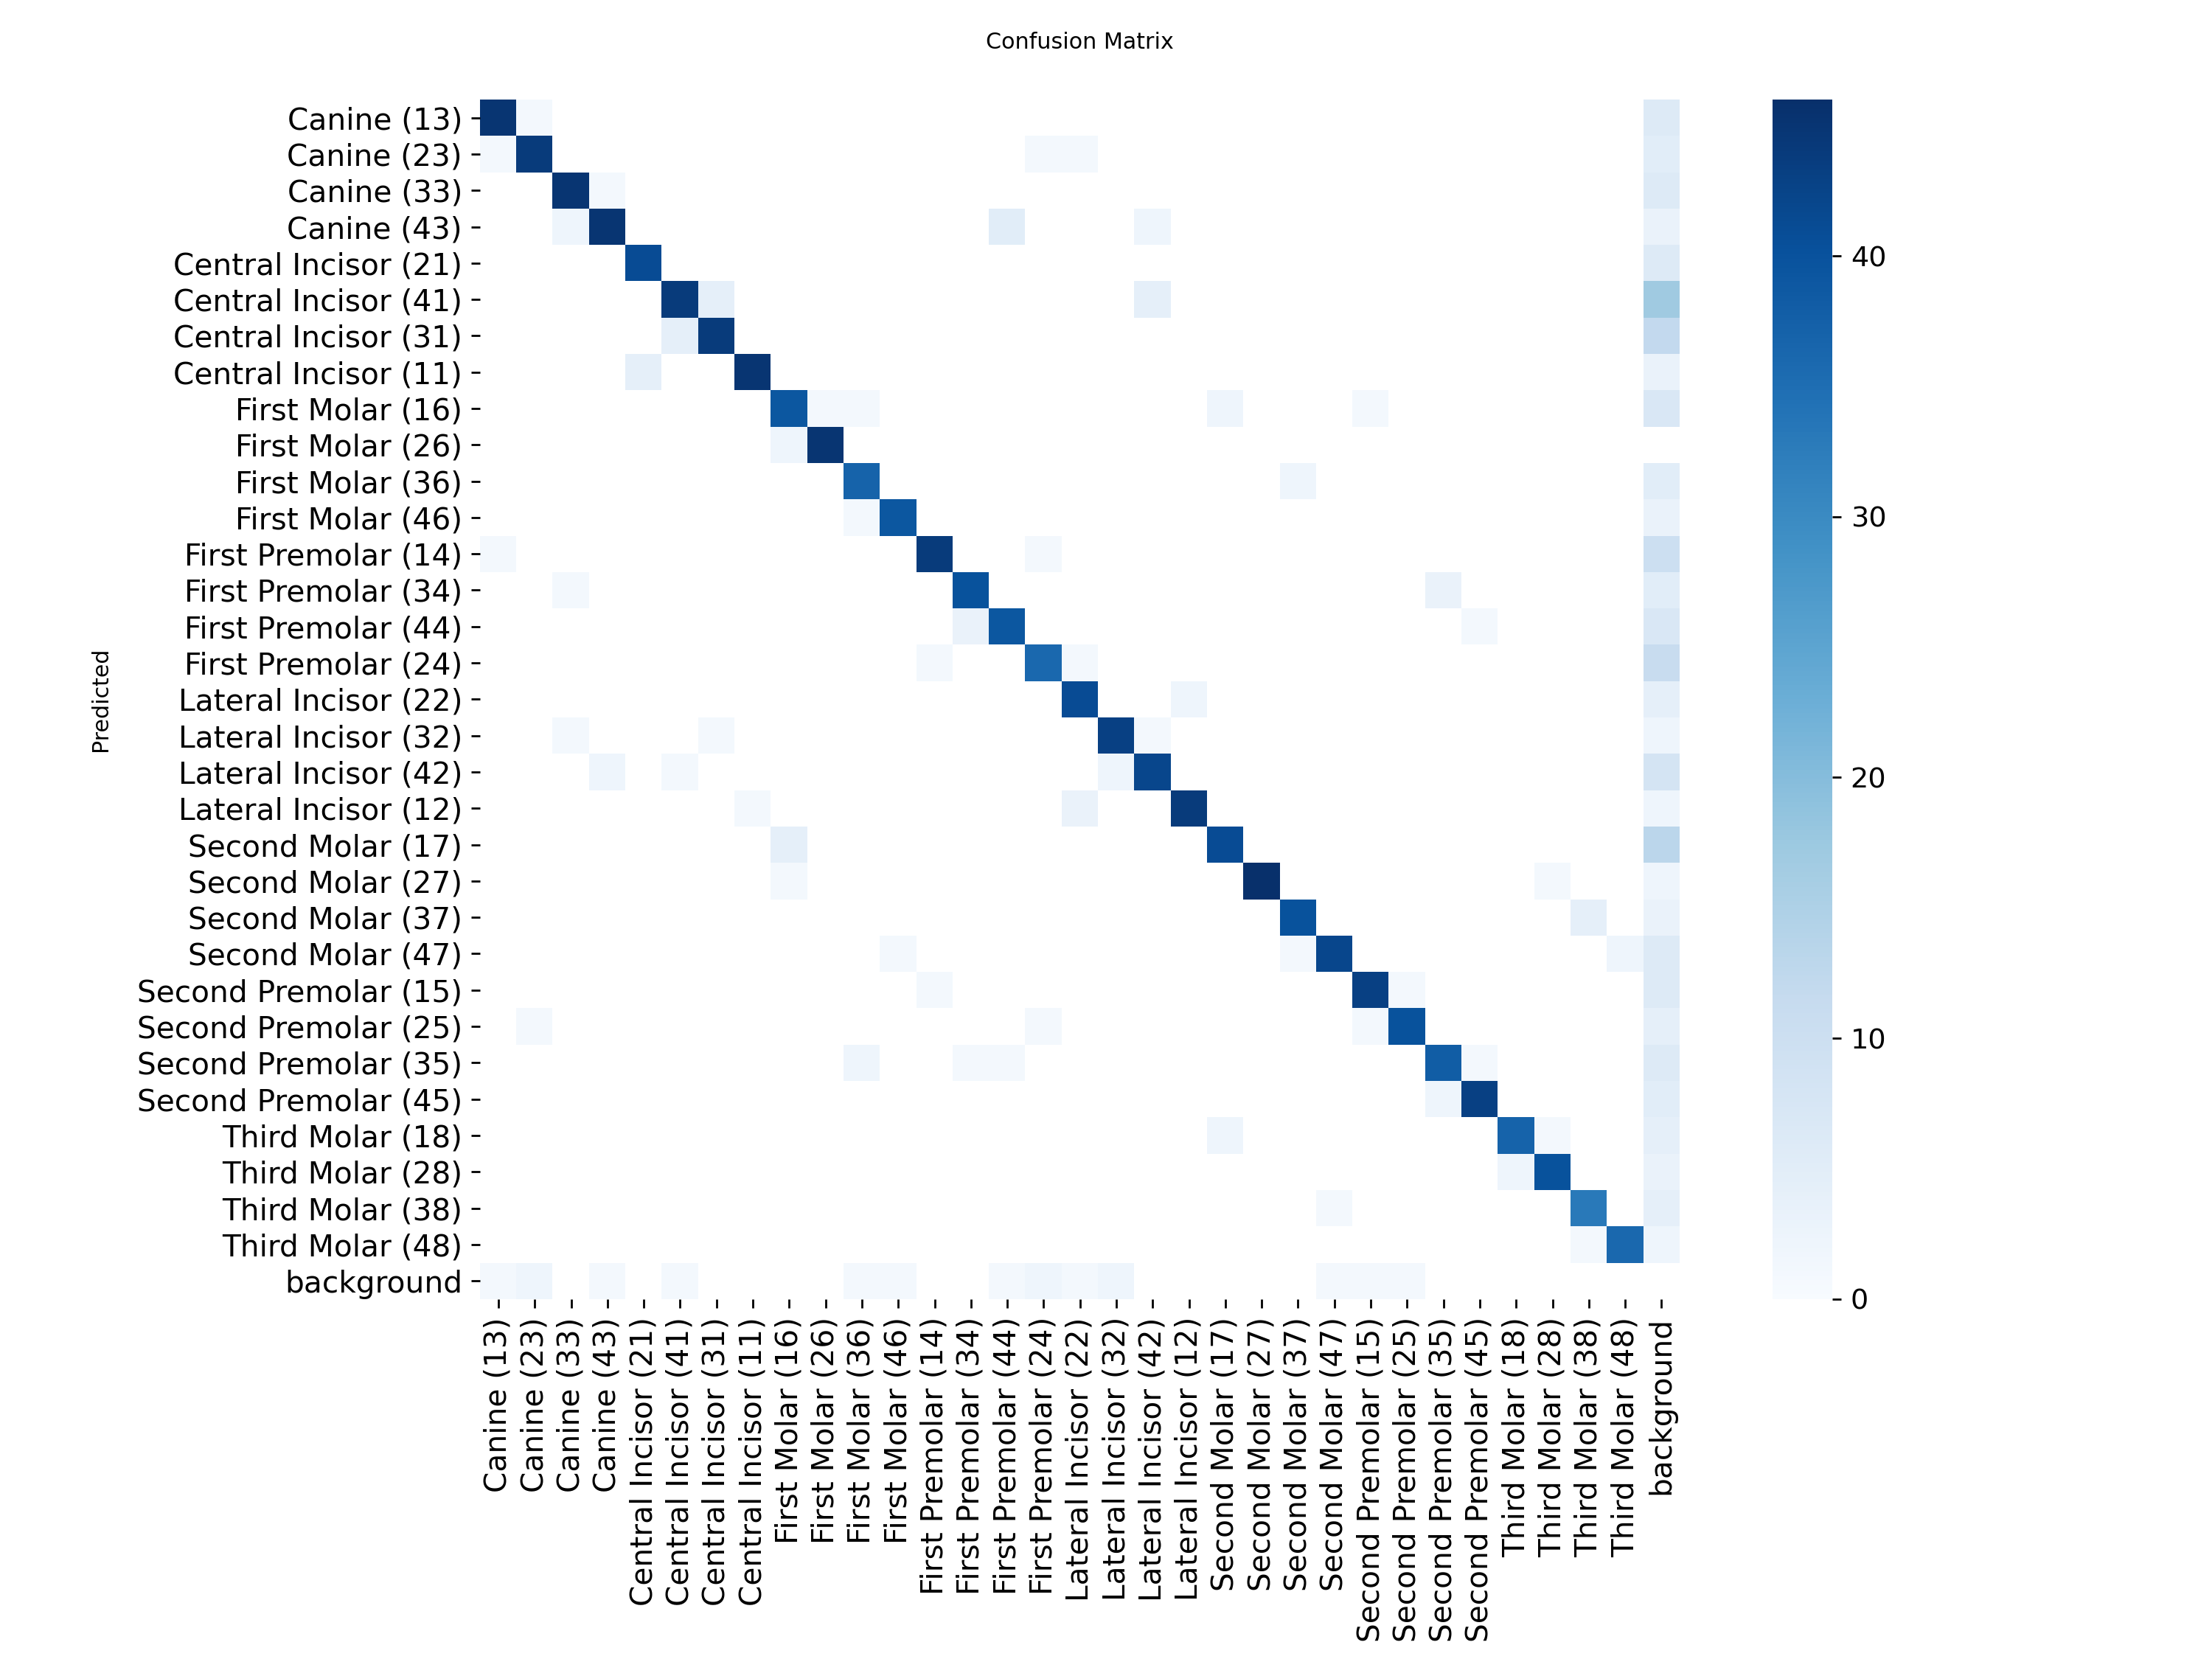

Metrics: {'precision': 0.917627256238526, 'recall': 0.91648610065637, 'mAP@50': 0.9593206283713822, 'mAP@50-95': 0.6721910974039881, 'run_dir': '/content/runs_v11/tooth_yolo11s_test'}


,precision,recall,mAP@50,mAP@50-95,run_dir
0,0.917627,0.916486,0.959321,0.672191,/content/runs_v11/tooth_yolo11s_test


In [3]:
# Call the YOLOv11 evaluator (uses your trained run path)
metrics_v11, dir_v11 = eval_ultra(
    '/content/runs_v11/tooth_yolo11s/weights/best.pt',
    data_yaml='/content/data.yaml',
    imgsz=640, conf=0.001, iou=0.6,
    project='/content/runs_v11', name='tooth_yolo11s_test'
)

# Optional: also print as a neat table
import pandas as pd
pd.DataFrame([metrics_v11])


In [7]:
# === KEY METRICS for YOLOv11/8 (Ultralytics), YOLOv5, YOLOv7 ===
import os, glob, re, yaml
from pathlib import Path
import pandas as pd
from typing import Optional

DATA_YAML = '/content/data.yaml'

# ---------- helpers ----------
def latest(pattern: str) -> Optional[str]:
    cands = sorted(glob.glob(pattern), key=os.path.getmtime, reverse=True)
    return cands[0] if cands else None

def ensure_ultralytics():
    try:
        from ultralytics import YOLO  # noqa
    except Exception:
        raise RuntimeError("Ultralytics not installed. Run: !pip -q install -U ultralytics")

def eval_ultra_ckpt(ckpt_path: str, project='/content/runs_eval', name='eval_ultra',
                    data_yaml=DATA_YAML, imgsz=640, conf=0.001, iou=0.6):
    """Evaluate an Ultralytics checkpoint (YOLOv11/8) on TEST and return metrics dict."""
    ensure_ultralytics()
    from ultralytics import YOLO
    model = YOLO(ckpt_path)
    res = model.val(
        data=data_yaml, split='test', imgsz=imgsz,
        conf=conf, iou=iou, plots=False, save_json=False,
        project=project, name=name, exist_ok=True, verbose=False
    )
    rd = getattr(res, "results_dict", {}) or {}
    def get(rd, *keys):
        for k in keys:
            if k in rd: return float(rd[k])
        return float('nan')
    out = {
        "model": Path(ckpt_path).name,
        "framework": "Ultralytics",
        "precision": get(rd, "metrics/precision(B)", "metrics/precision"),
        "recall":    get(rd, "metrics/recall(B)",    "metrics/recall"),
        "mAP@50":    get(rd, "metrics/mAP50(B)",     "metrics/mAP50"),
        "mAP@50-95": get(rd, "metrics/mAP50-95(B)",  "metrics/mAP50-95"),
        "ckpt_or_run": ckpt_path
    }
    run_dir = Path(res.save_dir)
    pd.DataFrame([out]).to_csv(run_dir/'key_metrics.csv', index=False)
    return out

def parse_results_txt(run_dir_glob: str, framework_name: str):
    """
    Parse YOLOv5/YOLOv7 results.txt:
    finds newest *test*/results.txt (or newest results.txt) and extracts 'all  P  R  mAP@.5  mAP@.5:.95'
    """
    res_txts = sorted(glob.glob(f"{run_dir_glob}/*test*/results.txt"), key=os.path.getmtime, reverse=True)
    if not res_txts:
        res_txts = sorted(glob.glob(f"{run_dir_glob}/*/results.txt"), key=os.path.getmtime, reverse=True)
    if not res_txts:
        return None
    res_txt = Path(res_txts[0])
    all_line = None
    for ln in res_txt.read_text().splitlines():
        if ln.strip().startswith("all "):
            all_line = ln; break
    if all_line is None:
        for ln in res_txt.read_text().splitlines():
            if "all" in ln:
                all_line = ln; break
    if all_line is None:
        return None
    nums = [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", all_line)]
    if len(nums) < 4:
        return None
    P, R, m50, m5095 = nums[-4], nums[-3], nums[-2], nums[-1]
    out = {
        "model": res_txt.parent.name,
        "framework": framework_name,
        "precision": P,
        "recall": R,
        "mAP@50": m50,
        "mAP@50-95": m5095,
        "ckpt_or_run": str(res_txt.parent)
    }
    pd.DataFrame([out]).to_csv(res_txt.parent/'key_metrics.csv', index=False)
    return out

# ---------- collect metrics ----------
rows = []

# Ultralytics YOLOv11 and YOLOv8 (best.pt preferred)
ckpt_v11 = latest("/content/runs_v11/*/weights/best.pt") or latest("/content/runs_v11/*/weights/last.pt")
ckpt_v8  = latest("runs/detect/*/weights/best.pt")       or latest("runs/detect/*/weights/last.pt")
print("Found ckpt_v11:", ckpt_v11)
print("Found ckpt_v8 :", ckpt_v8)

if ckpt_v11:
    rows.append(eval_ultra_ckpt(ckpt_v11, project='/content/runs_v11', name='tooth_yolo11s_test'))
if ckpt_v8:
    rows.append(eval_ultra_ckpt(ckpt_v8,  project='/content/runs_v8',  name='tooth_yolov8_test'))

# YOLOv5 & YOLOv7 (parse their results.txt from prior test runs)
m_v5 = parse_results_txt("/content/runs_v5", "YOLOv5")
if m_v5: rows.append(m_v5)
m_v7 = parse_results_txt("/content/runs_v7", "YOLOv7")
if m_v7: rows.append(m_v7)

assert rows, "No metrics found. Make sure you ran evaluations: Ultralytics .val() (v8/v11) and test.py/val.py (v7/v5)."

df = pd.DataFrame(rows).sort_values("mAP@50-95", ascending=False)
display(df)

# Save combined CSV
out_csv = "/content/key_metrics_all_models.csv"
df.to_csv(out_csv, index=False)
print("Saved combined key metrics to:", out_csv)


Found ckpt_v11: /content/runs_v11/tooth_yolo11s/weights/best.pt
Found ckpt_v8 : None
Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu128 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,425,184 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1920.4±187.5 MB/s, size: 75.5 KB)
val: Scanning /content/dataset/labels/test.cache... 51 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 51/51 88612.1it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 4.3it/s 0.9s
                   all         51       1436      0.918      0.916      0.959      0.672
Speed: 0.2ms preprocess, 10.4ms inference, 0.0ms loss, 1.2ms postprocess per image


,model,framework,precision,recall,mAP@50,mAP@50-95,ckpt_or_run
0,best.pt,Ultralytics,0.917627,0.916486,0.959321,0.672191,/content/runs_v11/tooth_yolo11s/weights/best.pt


Saved combined key metrics to: /content/key_metrics_all_models.csv


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_0.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['precision']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'precision'}, axis=1)
              .sort_values('precision', ascending=True))
  xs = counted['precision']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('precision', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('precision')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['recall']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'recall'}, axis=1)
              .sort_values('recall', ascending=True))
  xs = counted['recall']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('recall', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('recall')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['mAP@50']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'mAP@50'}, axis=1)
              .sort_values('mAP@50', ascending=True))
  xs = counted['mAP@50']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('mAP@50', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('mAP@50')
_ = plt.ylabel('count()')


[Ultralytics] Evaluating: /content/runs_v11/tooth_yolo11s/weights/best.pt
Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu128 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,425,184 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1811.6±495.6 MB/s, size: 76.5 KB)
val: Scanning /content/dataset/labels/test.cache... 51 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 51/51 72266.7it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 0.68it/s 5.9s
                   all         51       1436      0.918      0.916      0.959      0.672
Speed: 6.2ms preprocess, 20.0ms inference, 0.0ms loss, 3.6ms postprocess per image
Saving /content/runs_v11/tooth_yolo11s_test/predictions.json...
Results saved to /content/runs_v11/tooth_yolo11s_test

CONFUSION MATRIX → /content/runs_v11/tooth_yolo11s_test


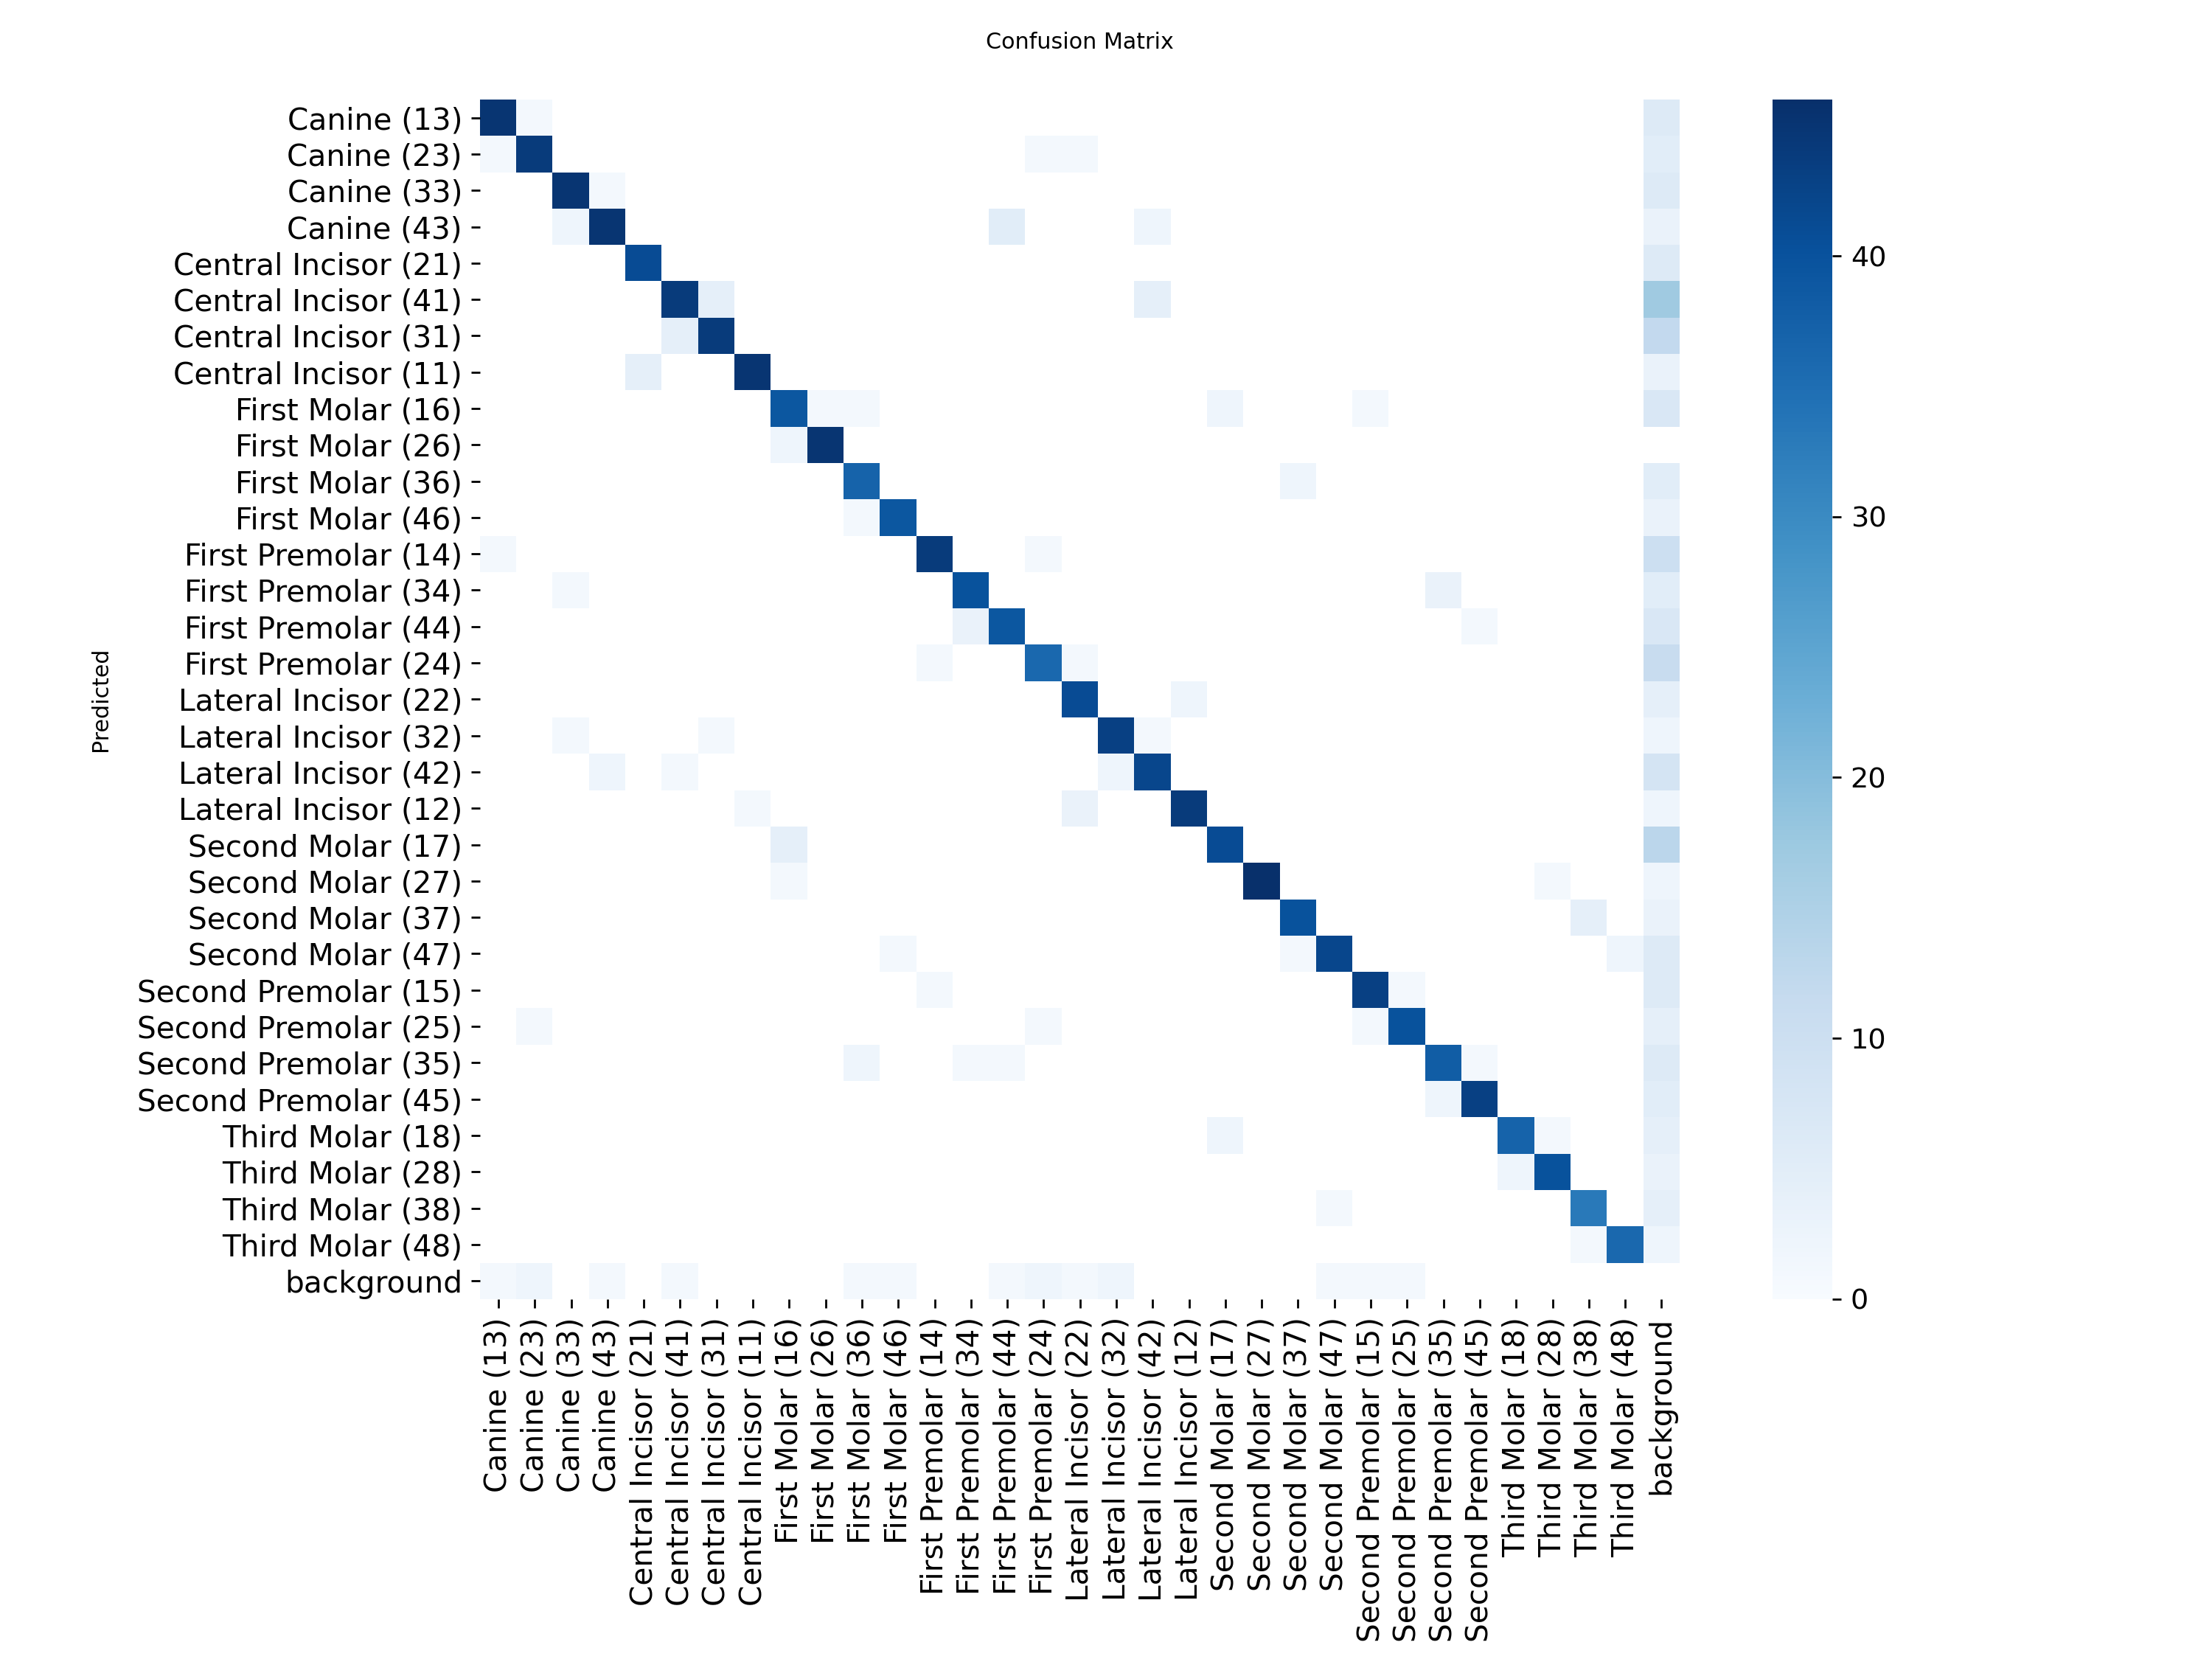

Key metrics: {'precision': 0.917627256238526, 'recall': 0.91648610065637, 'mAP@50': 0.9593206283713822, 'mAP@50-95': 0.6721910974039881, 'run_dir': '/content/runs_v11/tooth_yolo11s_test'}
YOLOv5 weights not found; cannot generate confusion matrix.
YOLOv7 weights not found; cannot generate confusion matrix.


In [9]:
# === Generate & SHOW confusion matrix for YOLOv11/8, YOLOv5, YOLOv7 ===
from pathlib import Path
from IPython.display import Image, display
import glob, os, yaml, re, pandas as pd

DATA_YAML = "/content/data.yaml"

def latest(pattern):
    c = sorted(glob.glob(pattern), key=os.path.getmtime, reverse=True)
    return c[0] if c else None

def show_if_exists(png_path, title=None):
    p = Path(png_path)
    if p.exists():
        if title: print(f"\n{title}")
        display(Image(filename=str(p), width=900))
        return True
    return False

# -------------------- Ultralytics (YOLOv11/YOLOv8) --------------------
def ensure_ultralytics():
    try:
        from ultralytics import YOLO  # noqa
        return True
    except Exception:
        return False

def eval_and_show_ultra(ckpt, project, name, imgsz=640, conf=0.001, iou=0.6):
    from ultralytics import YOLO
    print(f"\n[Ultralytics] Evaluating: {ckpt}")
    m = YOLO(ckpt)
    res = m.val(
        data=DATA_YAML, split='test', imgsz=imgsz,
        conf=conf, iou=iou, plots=True, save_json=True,
        project=project, name=name, exist_ok=True, verbose=False
    )
    run_dir = Path(res.save_dir)
    # Try standard filename
    if not show_if_exists(run_dir/"confusion_matrix.png", title=f"CONFUSION MATRIX → {run_dir}"):
        # Some versions write to 'confusion_matrix.png' only; just list PNGs in folder
        pngs = list(run_dir.glob("*.png"))
        if pngs:
            print(f"Showing first PNG (fallback) from {run_dir}:")
            display(Image(filename=str(pngs[0]), width=900))
        else:
            print(f"No confusion matrix PNG found in {run_dir}.")
    # Also dump key metrics CSV
    rd = getattr(res, "results_dict", {}) or {}
    def get(rd, *keys):
        for k in keys:
            if k in rd: return float(rd[k])
        return float('nan')
    metrics = {
        "precision": get(rd, "metrics/precision(B)", "metrics/precision"),
        "recall":    get(rd, "metrics/recall(B)",    "metrics/recall"),
        "mAP@50":    get(rd, "metrics/mAP50(B)",     "metrics/mAP50"),
        "mAP@50-95": get(rd, "metrics/mAP50-95(B)",  "metrics/mAP50-95"),
        "run_dir":   str(run_dir)
    }
    pd.DataFrame([metrics]).to_csv(run_dir/"key_metrics.csv", index=False)
    print("Key metrics:", metrics)

if ensure_ultralytics():
    ckpt_v11 = latest("/content/runs_v11/*/weights/best.pt") or latest("/content/runs_v11/*/weights/last.pt")
    ckpt_v8  = latest("runs/detect/*/weights/best.pt")       or latest("runs/detect/*/weights/last.pt")
    if ckpt_v11:
        eval_and_show_ultra(ckpt_v11, project="/content/runs_v11", name="tooth_yolo11s_test")
    if ckpt_v8:
        eval_and_show_ultra(ckpt_v8,  project="/content/runs_v8",  name="tooth_yolov8_test")
else:
    print("Ultralytics not installed; skipping YOLOv11/8.")

# -------------------- YOLOv5 (results from val.py --task test) --------------------
def ensure_yolov5_matrix():
    # Prefer test runs; else newest results.txt
    res_dirs = sorted({Path(p).parent for p in glob.glob("/content/runs_v5/*test*/results.txt")}, key=os.path.getmtime, reverse=True)
    if not res_dirs:
        res_dirs = sorted({Path(p).parent for p in glob.glob("/content/runs_v5/*/results.txt")}, key=os.path.getmtime, reverse=True)
    if res_dirs:
        for rd in res_dirs:
            if show_if_exists(rd/"confusion_matrix.png", title=f"CONFUSION MATRIX (YOLOv5) → {rd}"):
                return
    # If not found, try to create by running val.py quickly
    ckpt_v5 = latest("/content/runs_v5/*/weights/best.pt") or latest("/content/runs_v5/*/weights/last.pt")
    if ckpt_v5:
        print("\n[YOLOv5] Generating confusion matrix via quick val:")
        os.system(f'python /content/yolov5/val.py --img 640 --data {DATA_YAML} '
                  f'--weights "{ckpt_v5}" --task test --conf 0.001 --iou 0.6 '
                  f'--project /content/runs_v5 --name tooth_v5_test --exist-ok --plots --save-json')
        # Show after generation
        show_if_exists(Path("/content/runs_v5/tooth_v5_test")/"confusion_matrix.png",
                       title="CONFUSION MATRIX (YOLOv5) → /content/runs_v5/tooth_v5_test")
    else:
        print("YOLOv5 weights not found; cannot generate confusion matrix.")

ensure_yolov5_matrix()

# -------------------- YOLOv7 (results from test.py --task test) --------------------
def ensure_yolov7_matrix():
    res_dirs = sorted({Path(p).parent for p in glob.glob("/content/runs_v7/*test*/results.txt")}, key=os.path.getmtime, reverse=True)
    if res_dirs:
        for rd in res_dirs:
            if show_if_exists(rd/"confusion_matrix.png", title=f"CONFUSION MATRIX (YOLOv7) → {rd}"):
                return
    # If not found, try to create by running test.py quickly
    ckpt_v7 = latest("/content/runs_v7/*/weights/best.pt") or latest("/content/runs_v7/*/weights/last.pt")
    if ckpt_v7:
        print("\n[YOLOv7] Generating confusion matrix via quick test:")
        os.system(f'python /content/yolov7/test.py --data {DATA_YAML} --img-size 640 --batch-size 16 '
                  f'--conf-thres 0.001 --iou-thres 0.6 --device 0 --weights "{ckpt_v7}" '
                  f'--task test --project /content/runs_v7 --name tooth_v7_test --exist-ok --save-json')
        show_if_exists(Path("/content/runs_v7/tooth_v7_test")/"confusion_matrix.png",
                       title="CONFUSION MATRIX (YOLOv7) → /content/runs_v7/tooth_v7_test")
    else:
        print("YOLOv7 weights not found; cannot generate confusion matrix.")

ensure_yolov7_matrix()
